## Creating the heat metric

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
import pickle
from tqdm.notebook import tqdm

<a id=1></a>
## Load data

In [3]:
with open('bike_network.pkl', 'rb') as f:
    df = pickle.load(f)

<a id=2></a>
## Clean data

In [4]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 242475 entries, (6316199, 46388769, 0) to (11415605724, 11415605723, 0)
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   osmid            242475 non-null  int64   
 1   oneway           242475 non-null  bool    
 2   highway          242475 non-null  object  
 3   name             152358 non-null  object  
 4   width            242475 non-null  object  
 5   surface          242475 non-null  object  
 6   lit              53338 non-null   object  
 7   smoothness       50298 non-null   object  
 8   reversed         242475 non-null  bool    
 9   length           242475 non-null  float64 
 10  maxspeed         89952 non-null   object  
 11  lanes            26826 non-null   object  
 12  est_width        328 non-null     object  
 13  area             242475 non-null  float64 
 14  geometry         242475 non-null  geometry
 15  shadow_prop     

In [5]:
df.dropna(subset=['shadow_prop', 'avg_temperature', 'uhi'], inplace=True)

/Users/tom/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


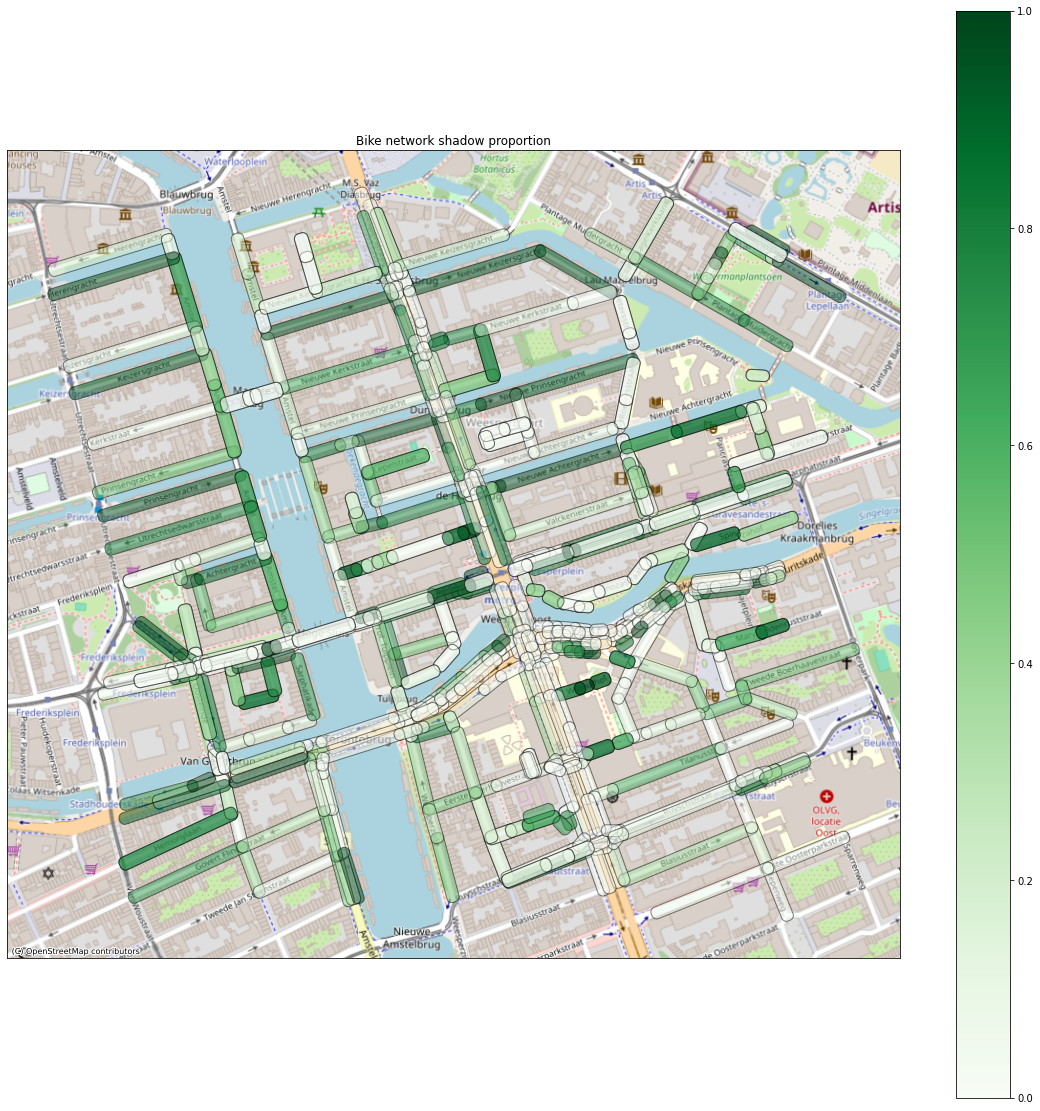

In [6]:
#crop the bike network polygons to area around roeterseilandcampus
bike_network_crop = df.cx[121833.302478:122779.132399, 485574.057764:486541.120493]
#
# bike_network_crop = bike_network.cx[119833.302478:120779.132399, 485574.057764:486541.120493]
#make all the polygons thicker
bike_network_crop.geometry = bike_network_crop.geometry.buffer(8)


#plot the bike network with the shadow proportions as color
#background as beige, color scale greens
fig, ax = plt.subplots(figsize=(20,20))
bike_network_crop.plot(column='shadow_prop', cmap='Greens', ax=ax, legend=True, alpha=0.5, edgecolor='black')
#add a basemap 

ctx.add_basemap(ax, crs='epsg:28992', source=ctx.providers.OpenStreetMap.Mapnik)
#add titles
ax.set_title('Bike network shadow proportion')
#remove ticks
ax.set_xticks([])
ax.set_yticks([])
#shrink colorbar

plt.show()

In [7]:
# #remove streets in bottom half of lengths
df = df[df['length'] > df['length'].median()]
len(df)

119423

In [8]:
# print the fraction of streets with a shadow proportion of 0
print('Streets with a shadow proportion of 0:',len(df[df['shadow_prop']==0])/len(df) * 100, '%')

Streets with a shadow proportion of 0: 62.56165060331762 %


<a id=4></a>
### Feature selection

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV

In [10]:
# Select features and target
features = ['surface', 'shadow_prop', 'uhi']
features = df[features]
X = pd.get_dummies(features, columns=['surface'])
y = df['avg_temperature']
X.head()

shadow_prop       uhi  surface_asphalt  \
u        v          key                                           
6316199  46388769   0       0.387141  2.111020            False   
46388769 46389218   0       0.000000  2.129300            False   
25596455 46356773   0       0.000000  1.861000            False   
46356773 4854477802 0       0.248447  1.914615            False   
         25596455   0       0.000000  1.861000            False   

                         surface_cobblestone  surface_compacted  \
u        v          key                                           
6316199  46388769   0                  False              False   
46388769 46389218   0                  False              False   
25596455 46356773   0                  False              False   
46356773 4854477802 0                  False              False   
         25596455   0                  False              False   

                         surface_concrete  surface_concrete-slabs  \
u        v          key                                             
6316199  46388769   0               False                   False   
46388769 46389218   0               False                   False   
25596455 46356773   0               False                   False   
46356773 4854477802 0               False                   False   
         25596455   0               False                   False   

                         surface_concrete:lanes  surface_concrete:plates  \
u        v          key                                                    
6316199  46388769   0                     False                    False   
46388769 46389218   0                     False                    False   
25596455 46356773   0                     False                    False   
46356773 4854477802 0                     False                    False   
         25596455   0                     False                    False   

                         surface_crushed_shell  ...  surface_red  \
u        v          key                         ...                
6316199  46388769   0                    False  ...        False   
46388769 46389218   0                    False  ...        False   
25596455 46356773   0                    False  ...        False   
46356773 4854477802 0                    False  ...        False   
         25596455   0                    False  ...        False   

                         surface_sand  surface_sett  surface_shells  \
u        v          key                                               
6316199  46388769   0           False         False           False   
46388769 46389218   0           False         False           False   
25596455 46356773   0           False         False           False   
46356773 4854477802 0           False         False           False   
         25596455   0           False         False           False   

                         surface_soil  surface_tegels  \
u        v          key                                 
6316199  46388769   0           False           False   
46388769 46389218   0           False           False   
25596455 46356773   0           False           False   
46356773 4854477802 0           False           False   
         25596455   0           False           False   

                         surface_unhewn_cobblestone  surface_unpaved  \
u        v          key                                                
6316199  46388769   0                         False            False   
46388769 46389218   0                         False            False   
25596455 46356773   0                         False            False   
46356773 4854477802 0                         False            False   
         25596455   0                         False            False   

                         surface_wood  surface_woodchips  
u        v          key                                   
6316199  46388769   0           False              False  
46388769 46

<a id=5></a>
### Train test split and baseline

In [11]:
# 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [12]:
# establish baseline
baseline = y_train.mean()

# create a list of predictions with the baseline
y_pred_baseline = [baseline] * len(y_train)

# calculate MAE, MSE, RMSE
r2_baseline = r2_score(y_train, y_pred_baseline)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
mse_baseline = mean_squared_error(y_train, y_pred_baseline)
rmse_baseline = np.sqrt(mse_baseline)

# print MAE, MSE, RMSE
print('Baseline Mean Absolute Error:', mae_baseline)
print('Baseline Mean Sqaured Error:', mse_baseline)
print('Baseline Root Mean Squared Error:', rmse_baseline)

Baseline Mean Absolute Error: 2.1689046670941763
Baseline Mean Sqaured Error: 7.464648423980702
Baseline Root Mean Squared Error: 2.7321508786999122


<a id=6></a>
### Hyperparameter tuning


In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# print best parameters
grid_search.best_params_

/Users/tom/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/tom/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/tom/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/tom/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated

{'max_depth': None, 'n_estimators': 200}

<a id=7></a>
### Train and evaluate the model

In [13]:
# Function to evaluate model performance
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print('R2:', r2)
    print('Mean Absolute Error:', mae)
    print('Mean Sqaured Error:', mse)
    print('Root Mean Squared Error:', rmse)
    
    return r2, mae, mse, rmse

In [14]:
# take the best estimator and fit it to the training data
rf = RandomForestRegressor(n_estimators=300, max_depth=None)
rf.fit(X_train, y_train)

# evaluate the model on the test data
evaluate(rf, X_test, y_test)

/Users/tom/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/tom/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


R2: 0.6105049326803142
Mean Absolute Error: 1.200279654828171
Mean Sqaured Error: 2.950710259859567
Root Mean Squared Error: 1.7177631559267905


(0.6105049326803142, 1.200279654828171, 2.950710259859567, 1.7177631559267905)

<a id=8></a>
### Analyse feature importance

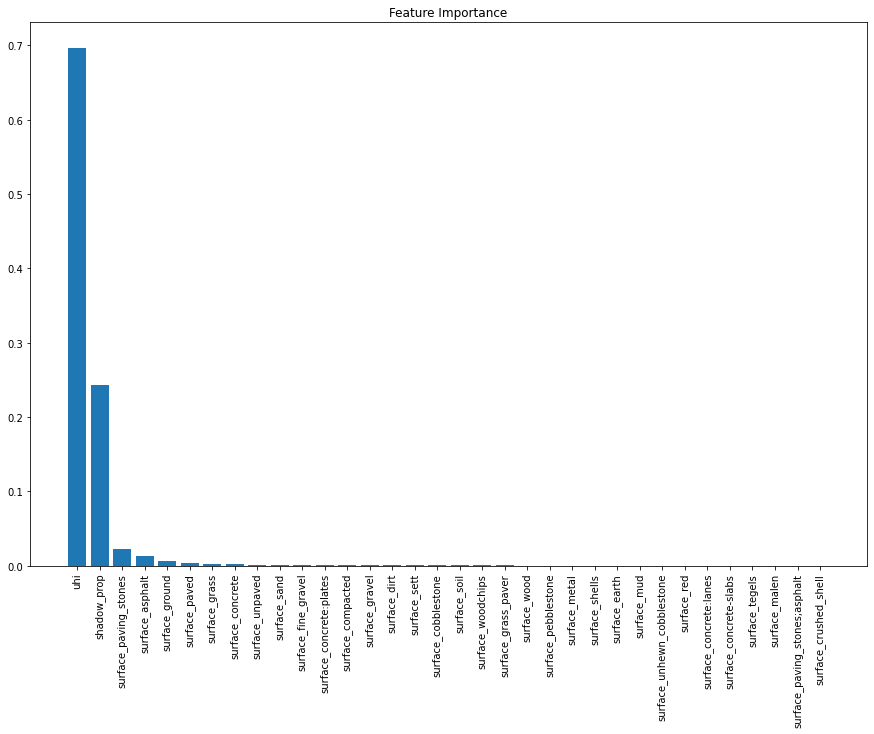

In [27]:
# Get feature importances
importances = rf.feature_importances_

# Sort feature importances in descending order
sorted_indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
feature_names = [X_train.columns[i] for i in sorted_indices]

# Create plot
plt.figure(figsize=(15,10))
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), importances[sorted_indices])
plt.xticks(range(X_train.shape[1]), feature_names, rotation=90)
plt.show()

/Users/tom/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


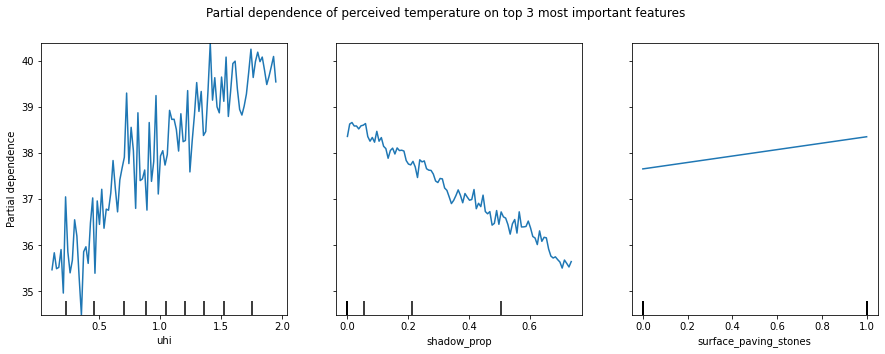

In [25]:
from sklearn.inspection import plot_partial_dependence

# top 3 most important features
top_3 = sorted_indices[:3]

# Plotting PDPs
fig = plot_partial_dependence(rf, X_train, features=top_3).figure_.suptitle('Partial dependence of perceived temperature on top 3 most important features')
fig = plt.gcf()
fig.set_size_inches(15, 5)
plt.show()